<a href="https://colab.research.google.com/github/OliverMateusDS/Automacoes-Cotidianas/blob/main/automacao_financeira_mercado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automação Financeira: Dólar, Ações e Notícias
Notebook para automatizar a coleta diária da cotação do dólar, das ações (PETR4.SA, VALE3.SA, ITUB4.SA) e de notícias relevantes sobre mercado financeiro em portais brasileiros. Os dados são armazenados em um banco de dados SQLite e visualizados por meio de gráficos.

## Bibliotecas necessárias

In [1]:
pip install lxml

In [2]:
import requests
import pandas as pd
import yfinance as yf
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import time
import re

## Cotação do Dólar (últimos 7 dias)
Coleta cotações do dólar usando a API AwesomeAPI.

In [3]:
# Pega cotações do dólar comercial dos últimos 7 dias
dias = 7
url = f'https://economia.awesomeapi.com.br/json/daily/USD-BRL/{dias}'
resposta = requests.get(url)
dolar_json = resposta.json()
df_dolar = pd.DataFrame(dolar_json)
df_dolar['data'] = pd.to_datetime(df_dolar['timestamp'], unit='s').dt.date
df_dolar['valor'] = df_dolar['bid'].astype(float)
df_dolar = df_dolar[['data', 'valor']].sort_values('data')
df_dolar

/tmp/ipython-input-3-1883142919.py:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_dolar['data'] = pd.to_datetime(df_dolar['timestamp'], unit='s').dt.date


,data,valor
6,2025-06-25,5.55040
5,2025-06-26,5.48080
4,2025-06-27,5.47450
3,2025-06-29,5.47286
2,2025-06-30,5.43020
1,2025-07-01,5.45750
0,2025-07-02,5.42880


## Cotações das Ações (últimos 30 dias)
Coleta cotações diárias das ações escolhidas usando yfinance.

In [4]:
# Defina os tickers das ações que deseja acompanhar
tickers = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA']
hoje = datetime.today()
inicio = (hoje - timedelta(days=30)).strftime('%Y-%m-%d')
fim = hoje.strftime('%Y-%m-%d')
dados_acoes = {}
for ticker in tickers:
    df = yf.download(ticker, start=inicio, end=fim)
    df['ticker'] = ticker
    dados_acoes[ticker] = df.reset_index()
df_acoes = pd.concat(dados_acoes.values(), ignore_index=True)
df_acoes = df_acoes[['Date', 'Close', 'Volume', 'ticker']].rename(columns={'Date':'data','Close':'fechamento','Volume':'volume'})
df_acoes['data'] = pd.to_datetime(df_acoes['data']).dt.date
df_acoes

/tmp/ipython-input-4-2517832694.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=inicio, end=fim)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4-2517832694.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=inicio, end=fim)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4-2517832694.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=inicio, end=fim)
[*********************100%***********************]  1 of 1 completed


Price         data fechamento                          volume           \
Ticker               PETR4.SA VALE3.SA   ITUB4.SA    PETR4.SA VALE3.SA   
0       2025-06-02  30.170834      NaN        NaN  35111000.0      NaN   
1       2025-06-03  30.180000      NaN        NaN  59828700.0      NaN   
2       2025-06-04  29.350000      NaN        NaN  41952900.0      NaN   
3       2025-06-05  29.360001      NaN        NaN  23774000.0      NaN   
4       2025-06-06  29.670000      NaN        NaN  28069300.0      NaN   
..             ...        ...      ...        ...         ...      ...   
58      2025-06-25        NaN      NaN  36.562527         NaN      NaN   
59      2025-06-26        NaN      NaN  36.292656         NaN      NaN   
60      2025-06-27        NaN      NaN  36.252674         NaN      NaN   
61      2025-06-30        NaN      NaN  36.932350         NaN      NaN   
62      2025-07-01        NaN      NaN  37.099998         NaN      NaN   

Price                 ticker  
Ticker    ITUB4.SA            
0              NaN  PETR4.SA  
1              NaN  PETR4.SA  
2              NaN  PETR4.SA  
3              NaN  PETR4.SA  
4              NaN  PETR4.SA  
..             ...       ...  
58      19790900.0  ITUB4.SA  
59      23026900.0  ITUB4.SA  
60      13825500.0  ITUB4.SA  
61      29818100.0  ITUB4.SA  
62      18167000.0  ITUB4.SA  

[63 rows x 8 columns]

## Scraping de Notícias do Mercado (em português)
Coleta notícias usando Google News para cada ação e para o termo 'dólar'.

In [5]:
def buscar_noticias_google(term, num=5):
    url = f'https://news.google.com/rss/search?q={term}+when:7d&hl=pt-BR&gl=BR&ceid=BR:pt-419'
    resp = requests.get(url)
    soup = BeautifulSoup(resp.content, features='xml')
    items = soup.findAll('item')[:num]
    noticias = []
    for item in items:
        titulo = item.title.text
        link = item.link.text
        pub = item.pubDate.text
        noticias.append({'busca': term, 'titulo': titulo, 'link': link, 'data_pub': pub})
    return noticias

# Buscando notícias para cada ação e para dólar
noticias = []
for termo in tickers + ['dólar']:
    termo_busca = termo.replace('.SA', '') if '.SA' in termo else termo
    noticias += buscar_noticias_google(termo_busca)
df_noticias = pd.DataFrame(noticias)
df_noticias['data_pub'] = pd.to_datetime(df_noticias['data_pub'])
df_noticias

/tmp/ipython-input-5-1511821344.py:5: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  items = soup.findAll('item')[:num]


,busca,titulo,link,data_pub
0,PETR4,O que esperar da Petrobras (PETR4) com o cessa...,https://news.google.com/rss/articles/CBMi8gFBV...,2025-06-30 13:53:00
1,PETR4,Petrobras (PETR4) conclui oferta de títulos de...,https://news.google.com/rss/articles/CBMikAFBV...,2025-06-30 22:25:24
2,PETR4,Petrobras (PETR4) conclui oferta de R$ 3 bilhõ...,https://news.google.com/rss/articles/CBMinwFBV...,2025-07-01 10:07:29
3,PETR4,Petrobras (PETR4) e 'juniores' descolam de ext...,https://news.google.com/rss/articles/CBMi7AFBV...,2025-06-30 18:44:29
4,PETR4,Petrobras (PETR4) ou Vale (VALE3): qual é a me...,https://news.google.com/rss/articles/CBMijwFBV...,2025-06-26 17:38:59
5,VALE3,"Vale (VALE3) dispara, na contramão do Ibovespa...",https://news.google.com/rss/articles/CBMitgFBV...,2025-07-02 16:08:49
6,VALE3,Vale (VALE3) realiza estudos para aplicar meta...,https://news.google.com/rss/articles/CBMiuwFBV...,2025-06-27 16:37:00
7,VALE3,Vale (VALE3) pretende realizar IPO de subsidiá...,https://news.google.com/rss/articles/CBMi5gFBV...,2025-06-30 14:00:00
8,VALE3,Todo investidor da Vale (VALE3) precisa ficar ...,https://news.google.com/rss/articles/CBMizgFBV...,2025-07-02 13:08:50
9,VALE3,Vale (VALE3) mais pressionada: mineradora redu...,https://news.google.com/rss/articles/CBMi5gFBV...,2025-07-02 14:52:18


## Salvando Dados no Banco SQLite

In [6]:
# Crie/Conecte ao banco de dados
con = sqlite3.connect('dados_mercado.db')

# Salva cada dataframe em uma tabela
df_dolar.to_sql('dolar', con, if_exists='replace', index=False)
df_acoes.to_sql('acoes', con, if_exists='replace', index=False)
df_noticias.to_sql('noticias', con, if_exists='replace', index=False)
con.close()
print('Dados salvos no banco dados_mercado.db')

Dados salvos no banco dados_mercado.db


## Visualização: Gráficos das Ações e do Dólar

/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:7065: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:7066: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


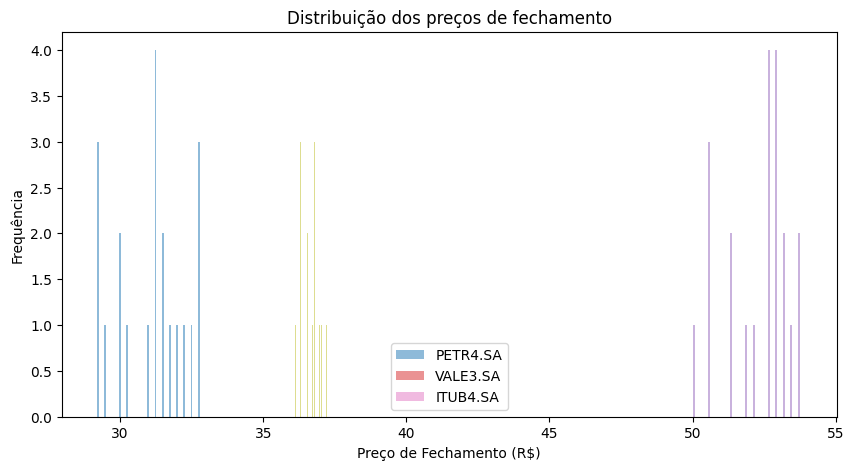

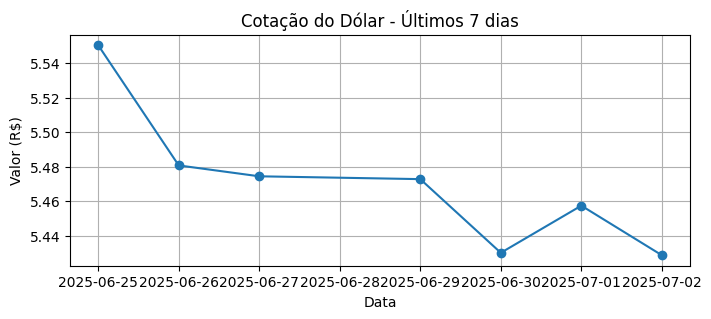

In [7]:
# Gráfico de distribuição dos fechamentos
plt.figure(figsize=(10,5))
for ticker in tickers:
    dados = df_acoes[df_acoes['ticker']==ticker]['fechamento']
    plt.hist(dados, bins=15, alpha=0.5, label=ticker)
plt.title('Distribuição dos preços de fechamento')
plt.xlabel('Preço de Fechamento (R$)')
plt.ylabel('Frequência')
plt.legend()
plt.show()

# Linha do dólar
plt.figure(figsize=(8,3))
plt.plot(df_dolar['data'], df_dolar['valor'], marker='o')
plt.title('Cotação do Dólar - Últimos 7 dias')
plt.xlabel('Data')
plt.ylabel('Valor (R$)')
plt.grid(True)
plt.show()

## Como agendar a execução automática?
Você pode agendar este notebook para rodar diariamente usando o Agendador de Tarefas do Windows ou um serviço tipo cron (Linux). Outra opção é exportar o código como script (.py) e agendar sua execução.